In [1]:
import spacy
import numpy as np
import pandas as pd
import csv 
import sys
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib 

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Analysis of the differences between MoodyLyrics and MoodyLyrics4Q

In the previous notebooks we found that the same ANN performs very good in MoodyLyrics (around 90% accuracy) and worse in MoodyLyrics4Q (around 70%), so our first step is to try to study the qualitative difference between the two datasets.<br>
We already know that there are duplicates between MoodyLyrics and MoodyLyrics4Q so our first step is to try to see the different classifications between these duplicated songs in the two datasets.

In [2]:
# Reading both original datasets (<Artist, Song, Emotion>)
moodyLyrics4QDF = pd.read_csv('../src/datasets/MoodyLyrics4Q.csv')
moodyLyricsDF   = pd.read_csv('../src/datasets/MoodyLyrics_cleaned.csv')
moodyLyricsDF.head()

,Unnamed: 0,Artist,Song,Emotion
0,0,.38 Special,Fantasy Girl,relaxed
1,1,.38 Special,Second Chance,happy
2,2,22-20s,Hold On,angry
3,3,3 Inches Of Blood,Trial Of Champions,angry
4,4,3 of Hearts,Is It Love,happy


In [3]:
moodyLyrics4QDF.columns = ['Unnamed: 0','Artist','Song','Emotion']
duplicates = pd.merge(moodyLyricsDF,moodyLyrics4QDF , how='inner',on = ['Artist','Song']).drop(['Unnamed: 0_x', 'Unnamed: 0_y'],axis=1)
duplicates.columns = ['Artist','Song','ML_emotion','ML4Q_emotion']
classified_different = duplicates[duplicates.ML_emotion != duplicates.ML4Q_emotion]

print('There are',classified_different.shape[0],'/', duplicates.shape[0], 'songs classified differently between MoodyLyrics and MoodyLyrics4Q duplicates')

classified_different.head(20)

There are 21 / 47 songs classified differently between MoodyLyrics and MoodyLyrics4Q duplicates


,Artist,Song,ML_emotion,ML4Q_emotion
0,Al Green,I'm Still In Love With You,happy,relaxed
6,Buzzcocks,Ever Fallen in Love?,happy,angry
7,Dead Boys,Sonic Reducer,sad,angry
9,Diana Krall,You're My Thrill,happy,relaxed
10,Donald Byrd,Think Twice,happy,relaxed
11,Ella Fitzgerald,Solitude,sad,relaxed
13,Ice Cube,Dirty Mack,sad,angry
16,Juanes,Me Enamora,sad,happy
20,Lit,Miserable,angry,sad
21,Louis Armstrong,Nobody Knows The Trouble I've Seen,angry,sad


However if we consider as equal Happy - Relaxed, and Angry - Sad, they are just 6/47!!<br>
Now, we consider some of these six...<br>
Let's start with Buzzcocks - Ever Fallen in Love?

<pre>
Buzzocks - Ever Fallen in Love?

You spurn my natural emotions
You make me feel I'm dirt and I'm hurt
And if I start a commotion
I run the risk of losing you and that's worse

Ever fallen in love with someone
Ever fallen in love, in love with someone
Ever fallen in love, in love with someone
You shouldn't have fallen in love with?

I can't see much of a future
Unless we find out what's to blame, what a shame
And we won't be together much longer
Unless we realize that we are the same

Ever fallen in love with someone
Ever fallen in love, in love with someone
Ever fallen in love, in love with someone
You shouldn't have fallen in love with

You disturb my natural emotions
You make me feel I'm dirt and I'm hurt
And if I start a commotion
I'll only end up losing you and that's worse</pre>

Does it sound more happy or angry? We would say angry! <br>
Now let's consider Ella Fitzgerald - Solitude.

<pre>
Ella Fitzgerald - Solitude

In my solitude you haunt me
With reveries of days gone by
In my solitude you taunt me
With memories that never die
I sit in my chair
Filled with despair
Nobody could be so sad
With gloom ev’rywhere
I sit and I stare
I know that I’ll soon go mad
In my solitude
I’m praying
Dear Lord above
Send back my love
I sit in my chair
I’m filled with despair
There’s no one could be so sad
With gloom ev’rywhere
I sit and I stare
I know that I’ll soon go mad
In my solitude
I’m praying
Dear Lord above
Send back my love </pre>

Does it sound more sad or relaxed? We would say sad with a relaxed tone. <br>
We now consider Juanes - Me Enamora even if it is not an english song.<br>
Here you can read the english translation!

<pre> Juanes - Me Enamora

I fell in love with you
from the depths
of my soul
and my heart it's there as an slave
of your eyes
 
I fell in love with you
with every ounce of my desires
and after You and I
I can imagine nothing else
 
I fell in love with you
like it's natural for a madman
and I swear that after You and I,
there will be nothing else
 
and I knew it was you
from the first moment
my eyes met yours
together two souls to live
 
Too big, that we can
defy the world
too free, not to learn that
what is born from love,
can't never be forgotten
 
I fell in love with you
and I'm still here in the same state
I fell in love with you,
I told you, and we're here
 
and I knew it was you
from the first moment
my eyes met yours
together two souls to live
 
Too big, that we can
defy the world
too free, not to learn
 
What is born from love,
can't never be forgotten
 </pre>

Does it sound more sad or happy? Defintely HAPPY!<br>
Now let's consider Richard Hell & the Voidoids - Love Comes in Spurts.

<pre>Richard Hell & the Voidoids - Love Comes in Spurts

I was a child
who wanted a love so wild
though tight as slow motion
But crazed with devotion
Babe, insane with devotion,

Just a whole other notion
I was fourteen and a half
and it wasn't no laugh

Love comes in spurts (oh no, it hurts!)
Love comes in spurts (oh no, it hurts!)
Love comes in spurts (it always hurts!)
Love comes in spurts (oh no!)

I just can't get wise
to those tragical lies
though I now know the facts
they still cut like an axe

baby, love comes in spurts
in dangerous flirts
and it murders your heart
they didn't tell you that part, baby!

Love comes in spurts (oh no!)
Love comes in spurts (oh no, it hurts!)
Love comes in spurts (oh no, it hurts!)
Love comes in spurts (it always!)

I just can't get wise
to those tragical lies
though I now know the facts
they still cut like an axe

baby, love comes in spurts
in dangerous flirts
and it murders your heart
they didn't tell you that part, baby!</pre>

Does it sound more happy or angry? We would say angry! <br>

Last one, let's consider Simon & Garfunkel - Patterns

<pre>Simon & Garfunkel - Patterns<br>

The night sets softly
With the hush of falling leaves
Casting shivering shadows
On the houses through the trees
And the light from a street lamp
Paints a pattern on my wall
Like the pieces of a puzzle
Or a child's uneven scrawl

Up a narrow flight of stairs
In a narrow little room
As I lie upon my bed
In the early evening gloom
Impaled on my wall
My eyes can dimly see
The pattern of my life
And the puzzle that is me

From the moment of my birth
To the instant of my death
There are patterns I must follow
Just as I must breathe each breath
Like a rat in a maze
The path before me lies
And the pattern never alters
Until the rat dies

And the pattern still remains
On the wall where darkness fell
And it's fitting that it should
For in darkness I must dwell
Like the color of my skin
Or the day that I grow old
My life is made of patterns
That can scarcely be controlled

Does it sound more sad or relaxed? This time we would say sad. 

## Conclusion
Not enough elements to say which dataset is better, but over 46 duplicates just 6 are classified totally different. 

# Model Selection

In [4]:
# read the featurized datasets (<Lyrics + features>)
moodyLyrics4QFeat = pd.read_csv('../src/datasets/MoodyLyrics4Q_featurized_fasttext.csv')
moodyLyricsFeat = pd.read_csv('../src/datasets/MoodyLyrics_featurized.csv')

In [5]:
selected_columns = [
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]
# Reduced dataset
r_moodyLyrics4QFeat = moodyLyrics4QFeat[selected_columns]
r_moodyLyricsFeat = moodyLyricsFeat[selected_columns]

In [6]:
# Function to get X and y of the correct shape 
# X = (..., 310)
# y = (...,)
def get_X_y(dataset, emotion=True):
    if emotion is True:
        tmp_df = dataset.drop(['EMOTION'], axis=1)
    else:
        tmp_df = dataset
    X = list()
    for (i, row) in tmp_df.iterrows():
        sub_list = list()
        for field in row:
            if type(field) == str:
                field = field[1:-1].split()
                sub_list += [float(x.replace('\n','')) for x in field]
            else:
                sub_list.append(field)
        X.append(np.array(sub_list))
    X = np.array(X)
    if emotion is True:
        y = dataset['EMOTION'].as_matrix().T
        return X, y
    else:
        return X

# Get X and y for Neural Network
# X_nn = (..., 310) but scaled
# y_nn = (..., 4)
def get_Xnn_ynn(X, y, save_info=False, scaler_filename='', encoder_filename=''):
    encoder = LabelEncoder()
    encoded_y = encoder.fit_transform(y)
    #print(encoder.inverse_transform([0, 1, 2, 3]))
    y_nn = np_utils.to_categorical(encoded_y)

    sc = StandardScaler()
    X_nn = sc.fit_transform(X)
    if save_info:
        joblib.dump(sc, scaler_filename)
        joblib.dump(encoder, encoder_filename)
    return X_nn, y_nn

## The model

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=310):
    classifier = Sequential()
    
    # Add input layer
    classifier = Sequential()
    # Add hidden layer
    classifier.add(Dense(units = 50, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
            
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'glorot_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [8]:
accuracies = np.zeros((5,1))

## First Attempt: TRAIN:moodyLyrics TEST:moodyLyrics4Q

In [9]:
'''
Here we try to use moodyLyricsFeat as training set
and moodyLyrics4QFeat as test set 
'''
X_train, y_train = get_X_y(r_moodyLyricsFeat)
X_train_nn, y_train_nn = get_Xnn_ynn(X_train, y_train)

X_test, y_test = get_X_y(r_moodyLyrics4QFeat)
X_test_nn, y_test_nn = get_Xnn_ynn(X_test,y_test)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 64, epochs = 100, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

accuracies[0] = accuracy

Accuracy: 33.32


## Second Attempt: TRAIN: moodyLyrics4Q, TEST: moodyLyrics

In [10]:
'''
Here we try to use moodyLyrics4QFeat as training set
and moodyLyricsFeat as test set 
'''
X_train, y_train = get_X_y(r_moodyLyrics4QFeat)
X_train_nn, y_train_nn = get_Xnn_ynn(X_train, y_train)

X_test, y_test = get_X_y(r_moodyLyricsFeat)
X_test_nn, y_test_nn = get_Xnn_ynn(X_test,y_test)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 64, epochs = 100, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

accuracies[1] = accuracy

Accuracy: 37.57


## Third Attempt: MoodyLyrics Alone

In [11]:
'''
Here we try to use moodyLyricsFeat alone, both for training and for test
'''
X, y = get_X_y(r_moodyLyricsFeat)
X_nn, y_nn = get_Xnn_ynn(X, y, True, '../src/models/ml_alone_scaler.pkl','../src/models/ml_alone_encoder.pkl')

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 64, epochs = 100, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))
filename = '../src/models/ml_alone.h5'
classifier.save(filename)
print('Classifier saved to', filename)
accuracies[2] = accuracy


Accuracy: 90.96
Classifier saved to ../src/models/ml_alone.h5


## Fourth attempt: MoodyLyrics4Q alone

In [14]:
'''
Here we try to use moodyLyrics4QFeat alone, both for training and for test
'''
X, y = get_X_y(r_moodyLyrics4QFeat)
X_nn, y_nn = get_Xnn_ynn(X, y, True, '../src/models/ml4q_alone_scaler.pkl','../src/models/ml4q_alone_encoder.pkl')

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 64, epochs = 100, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = '../src/models/ml4q_alone.h5'
classifier.save(filename)
print('Classifier saved to', filename)
accuracies[3] = accuracy

Accuracy: 60.31
Classifier saved to ../src/models/ml4q_alone.h5


## Fifth Attempt: Together

In [15]:
'''
Here we try to use moodyLyricsFeat + moodyLyrics4QFeat together
'''

joint_dataset = pd.concat([r_moodyLyricsFeat , r_moodyLyrics4QFeat])
X, y = get_X_y(joint_dataset)
X_nn, y_nn = get_Xnn_ynn(X, y, True, '../src/models/ml_ml4q_scaler.pkl','../src/models/ml_ml4q_encoder.pkl')

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 64, epochs = 100, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = '../src/models/ml_ml4q.h5'
classifier.save(filename)
print('Classifier saved to', filename)
accuracies[4] = accuracy

Accuracy: 68.44
Classifier saved to ../src/models/ml_ml4q.h5


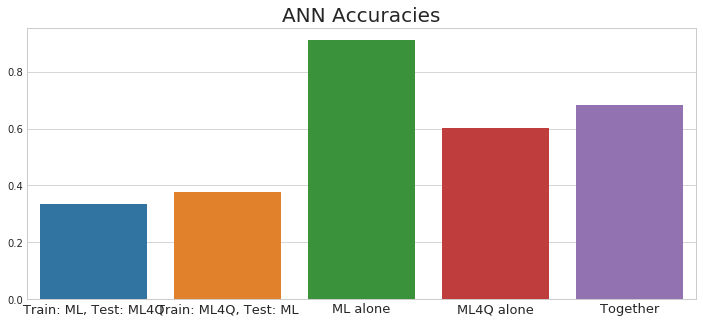

In [16]:
labels = ['Train: ML, Test: ML4Q', 'Train: ML4Q, Test: ML','ML alone','ML4Q alone','Together']

plt.figure(figsize = (12,5))
ax = sns.barplot(x=np.array(range(5)), y=accuracies.reshape(-1))
ax.set_title('ANN Accuracies',fontsize=20)
b = ax.set_xticklabels(labels, fontsize=13)

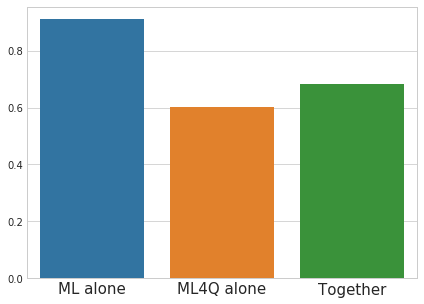

In [17]:
labels = ['ML alone','ML4Q alone','Together']
plt.figure(figsize = (7,5))
ax = sns.barplot(x=np.array(range(3)), y=accuracies.reshape(-1)[2:])
#ax.set_title('ANN Accuracies',fontsize=20)
b = ax.set_xticklabels(labels, fontsize=15)
plt.savefig('../Report/chapters/chapter4/images/ANN_accuracies.png')

# Playlist Test File

In [18]:
emotion_labels = {'^rage!': 'angry', 'crying$': 'sad', 'party!': 'happy', 'sleeping':'relaxed'}
path = '../src/datasets/silver_standard/'

playlist_test = list()
songs = list()

for dir in os.listdir(path):
    if dir in emotion_labels:
        for filename in os.listdir(os.path.join(path,dir)):
            # Create a list with <Playlist_PID, Playlist_Emotion>
            ppid = filename.split('.')[0]
            pemotion = emotion_labels[dir]
            playlist_test.append((ppid, pemotion))
            # Create a list with <Playlist_PID, seqID, TrackName, ArtistName>
            count = 0
            f = open(os.path.join(path, dir+'/'+filename), 'r')
            reader = csv.reader(f)
            headers = next(reader, None)
            for row in reader:
                songs.append((ppid, count, row[2], row[4]))
                count += 1

playlist_testDF = pd.DataFrame(playlist_test, columns=['PID','Emotion'])
songs_testDF = pd.DataFrame(songs, columns=['PID','SeqID','Title','Artist'])          

playlist_testDF.to_csv(os.path.join(path, 'playlist_test.csv'))
songs_testDF.to_csv(os.path.join(path, 'songs_test.csv'))

In [19]:
playlist_testDF.head(5)

,PID,Emotion
0,86626,sad
1,22628,sad
2,61723,sad
3,44631,sad
4,27101,sad


In [20]:
songs_testDF.head()

,PID,SeqID,Title,Artist
0,86626,0,All I Have To Do Is Dream,The Everly Brothers
1,86626,1,Only You (And You Alone),The Platters
2,86626,2,Unchained Melody,The Righteous Brothers
3,86626,3,Be My Baby,The Ronettes
4,86626,4,In The Still of the Night,The Five Satins


# Classify Playlist

## Generate featurized song DF

### Download lyrics

In [ ]:
import lyricwikia 
path = './../src/datasets/silver_standard/lyrics'
count = 0
errors = 0
total = len(songs_testDF)
for idx, row in songs_testDF.iterrows():
    try: 
        lyric = lyricwikia.get_lyrics(row['Artist'], row['Title'])
        filename = row['PID'] + '_' + row['Artist'] + '_' + row['Title'] + '.txt'
        filename = filename.replace("/", " ")
        with open(os.path.join(path, filename), 'w') as sfile:
            sfile.write(lyric)
        count += 1
        sys.stdout.write("\r" + str(count) + '/' + str(total))
        sys.stdout.flush()
    except lyricwikia.LyricsNotFound:
        errors += 1
        #print('Could not download', row['Artist'], row['Title'])
        
print(', ', errors, 'errors over', len(songs_testDF))

319/2081

## Song Classification

In [63]:
'''
First we have to create a new dataset with the songs for which
we succeed in downloading the lyrics
'''
path = '../src/datasets/silver_standard/lyrics'
songs = list()
count = 0
pid = 2100
for song in os.listdir(path):
    row = song.split('_')
    if len(row) == 3:
        if (row[0] != pid):
            count = 0
        pid, artist, title = row
        title = title.split('.')[0]
        songs.append((pid,count,title,artist))
        count += 1

songsDF = pd.DataFrame(data = songs, columns = ['PID','SeqID','Title','Artist'])
print('Total songs in the dataset', len(songsDF),'instead of', len(songs_testDF))

Total songs in the dataset 1536 instead of 2081


In [12]:
songsDF.to_csv('./datasets/silver_standard/songsDF.csv')

In [23]:
print(set(songs_testDF['PID']) - set(songsDF['PID']))

{'3553', '357827', '2575', '10224', '18734', '12321', '23544', '46146', '22628', '66984', '130767', '27101', '24769', '317182', '6721', '597121', '24143', '213226', '9655', '21217', '2100', '66889', '863720', '8570', '51818', '98451', '10572', '3529', '61723', '88155', '454776', '10400', '176336', '67781', '10325', '2466', '16036', '8658', '44631', '86626'}


In [22]:
songsDF = pd.read_csv('../src/datasets/silver_standard/songsDF.csv')

There were 40 playlists.
Now, there are 38 playlists.


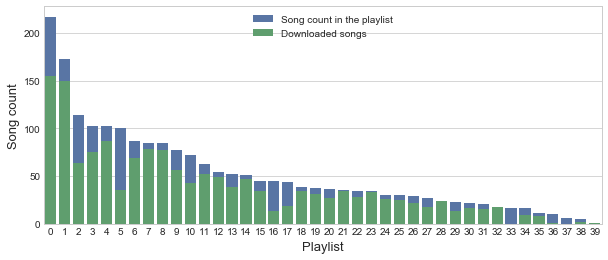

In [29]:
'''
Since we know that we weren't able to download all the lyrics
we want to see how this has impacted our playlists 
'''

before = songs_testDF['PID'].value_counts().sort_index()
after = songsDF['PID'].value_counts().sort_index()
df = pd.concat([before, after], axis=1)
df.columns = ['Before','After']
df = df.sort_values(by = 'Before', ascending=False)

print('There were', len(before), 'playlists.')
print('Now, there are',len(after),'playlists.')
plt.figure(figsize=(10,4 ))
#plt.title('Really available songs for playlist',fontsize=20, fontweight='bold')
ax = sns.barplot(x=np.array(range(len(df))),y=df['Before'], color='b', label='Song count in the playlist')
ax = sns.barplot(x=np.array(range(len(df))),y=df['After'], ax=ax, color='g', label='Downloaded songs')
plt.legend()
b = ax.set_xlabel('Playlist',fontsize=13)
b = ax.set_ylabel('Song count',fontsize=13)
plt.savefig('../Report/chapters/chapter6/images/silver_standard_available_songs.png')

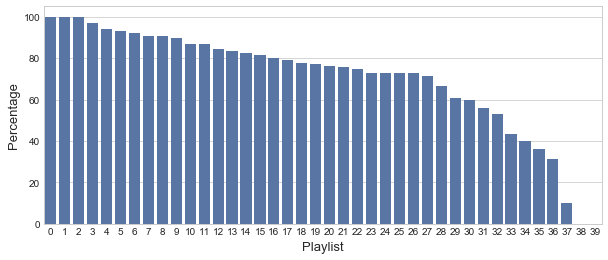

In [30]:
percentage = df['After']/df['Before'] * 100
percentage = percentage.sort_values(ascending=False)
plt.figure(figsize=(10,4 ))
#plt.title('Percentage of available songs per playlist',fontsize=20, fontweight='bold')
ax = sns.barplot(x=np.array(range(len(before))),y=percentage, color='b')
b = ax.set_xlabel('Playlist',fontsize=13)
b = ax.set_ylabel('Percentage',fontsize=13)
plt.savefig('../Report/chapters/chapter6/images/silver_standard_percentage_available_songs.png')

In [ ]:
'''
Now we want to featurize our song dataset

FIRST: we load the spaCy model

'''
import spacy
from spacy.language import Language
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa
import io

import numpy as np

# Use FastText
vectors_loc = '../src/models/wiki-news-300d-1M-subword.vec'

nlp = Language()
with open(vectors_loc, 'rb') as file_:
    header = file_.readline()
    nr_row, nr_dim = header.split()
    nlp.vocab.reset_vectors(width=int(nr_dim))
    for line in file_:
        line = line.rstrip().decode('utf8')
        pieces = line.rsplit(' ', int(nr_dim))
        word = pieces[0]
        vector = np.asarray([float(v) for v in pieces[1:]], dtype='f')
        nlp.vocab.set_vector(word, vector)  # add the vectors to the vocab

path = './../src/datasets/silver_standard/lyrics'
count = 0

In [ ]:
'''
SECOND: we featurize the dataset 
'''
import song_featurize as sf
import utils.progress as progress

import pandas as pd

ML4Q_PATH = '../src/datasets/MoodyLyrics4Q.csv'

df = pd.read_csv(ML4Q_PATH)

X = list()
total = len(df)
i = 0
for idx, row in songsDF.iterrows():
    progress.progress(i, total, 'Parsed songs')
    point = sf.featurize(row['PID'], row['Artist'], row['Title'])
    if point is not None:
        X.append(point)
    i += 1


songsFeat = pd.DataFrame(X, labels=[
    'ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
    'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
    'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
    'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
    'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
    'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
    'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
    'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
    'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
    'SENTIMENT', 'SUBJECTIVITY'])

songsFeat.to_csv('./../src/datasets/silver_standard/songs_featurized_fasttext.csv')

In [24]:
'''
SECOND: we featurize the dataset 
'''
rows = list() 
for idx, row in songsDF.iterrows():
    fname = str(row['PID']) + '_' + row['Artist'] + '_' + row['Title'] + '.txt'
    fname = os.path.join(path, fname)
    if os.path.lexists(fname):
        with io.open(fname, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
            lyric_doc = nlp(content)
            title_doc = nlp(row['Title'])

            lyric = preprocess(content)#lyric_doc.text)
            features = feature_extraction(lyric, row['Title'])

            freq = features['frequencies'] 

            sentiment = sa.analyse(content)

            elem = (
              row['PID'], row['SeqID'],
              row['Artist'], row['Title'],
              lyric_doc.vector, title_doc.vector,
              features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
              #get_slang_counts(lyric),
              features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
              count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
              features['rhymes'],#get_rhymes(lyric),
              features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
              freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
              freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
              freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
              freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
              # Sentiment analysis stuff
              sentiment[0], sentiment[1]
            )

            rows.append(elem)
            count += 1
            sys.stdout.write("\r" + str(count) + '/' + str(len(songsDF)))
            sys.stdout.flush()
            
            
songsFeat = pd.DataFrame(rows)
songsFeat.columns = ['PLAYLIST_PID','SEQ_ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
        'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
        'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
        'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
        'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
        'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
        'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
        'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
        'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
        'SENTIMENT', 'SUBJECTIVITY'
  ]

427/1536

For some reason we only featurized 1461 songs instead of 1536

In [22]:
songsFeat.to_csv('./datasets/silver_standard/songs_featurized.csv')
print(songsFeat.shape)

NameError: name 'songsFeat' is not defined

In [24]:
songsFeat = pd.read_csv('./../src/datasets/silver_standard/silver_standard_featurized_fasttext.csv')

In [25]:
'''
Now we can finally classify songs 

'''
songsFeat = pd.read_csv('../src/datasets/silver_standard/silver_standard_featurized_fasttext.csv')
path = '../src/models'
selected_columns = [
   'PLAYLIST_PID',
   'SEQ_ID',
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY'
]
r_songsFeat = songsFeat[selected_columns]
X = get_X_y(r_songsFeat.drop(['PLAYLIST_PID','SEQ_ID'],axis=1), emotion=False)

'''
At the end we just have 3 models:
    - MoodyLyrics alone
    - MoodyLyrics4Q alone
    - both together
'''
n_models = 3

predictions = np.ones((n_models, len(X), 4))
models = ['ml_alone.h5','ml4q_alone.h5', 'ml_ml4q.h5']
scalers = ['ml_alone_scaler.pkl','ml4q_alone_scaler.pkl', 'ml_ml4q_scaler.pkl']
encoders = ['ml_alone_encoder.pkl','ml4q_alone_encoder.pkl', 'ml_ml4q_encoder.pkl']
i = 0

for i in range(n_models):
    model = load_model(os.path.join(path,models[i]))
    sc = joblib.load(os.path.join(path,scalers[i]))
    encoder = joblib.load(os.path.join(path,encoders[i]))
    X_nn = sc.transform(X)
    y_pred = model.predict(X_nn)
    predictions[i,:,:] = y_pred
    i += 1

In [26]:
'''
Now we want to append the Emotion columns (4), to SongsFeat
considering the 3 different models. 
Let's start with the first --- ml_alone.h5
'''

predictionsDF = pd.DataFrame(data = predictions[0], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml_alone = pd.concat([songsFeat, predictionsDF], axis=1)

'''
Now the second --- ml4q_alone.h5
'''
predictionsDF = pd.DataFrame(data = predictions[1], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml4q_alone = pd.concat([songsFeat, predictionsDF], axis=1)


'''
And the third --- ml_ml4q.h5
'''
predictionsDF = pd.DataFrame(data = predictions[2], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml_ml4q = pd.concat([songsFeat, predictionsDF], axis=1)


In [27]:
songsFeat_ml_alone.to_csv('../src/datasets/silver_standard/Songs_c_ML.csv')
songsFeat_ml4q_alone.to_csv('../src/datasets/silver_standard/Songs_c_ML4Q.csv')
songsFeat_ml_ml4q.to_csv('../src/datasets/silver_standard/Songs_c_MLML4Q.csv')

## Playlist Classification

Now we are ready to classify playlists.<br>
First step: we want to create a dataframe with 'Playlist_pid, playlist_emotion_vector', where 'emotion_vector' is the mean of the emotion vectors of the songs in that playlist.

In [28]:
emotion_labels = ['angry', 'happy','relaxed' ,'sad']
map_mean = dict()
for emotion in emotion_labels:
    map_mean[emotion] = 'mean'
songsFeat_ml_alone.groupby('PLAYLIST_PID', as_index=False).head(10).groupby('PLAYLIST_PID', as_index=False).agg(map_mean)

,PLAYLIST_PID,angry,relaxed,happy,sad
0,2100,0.155675,0.087579,2.331348e-06,0.756744
1,2466,0.044257,0.038610,6.623047e-07,0.917132
2,2575,0.839397,0.064997,4.885369e-06,0.095601
3,3529,0.086572,0.037950,1.029888e-06,0.875478
4,3553,0.153209,0.051783,1.865300e-06,0.795006
5,6721,0.123534,0.063842,1.563075e-06,0.812622
6,8570,0.126381,0.035296,9.985659e-07,0.838322
7,8658,0.395356,0.044964,3.173961e-06,0.559676
8,9655,0.198044,0.108573,2.935416e-06,0.693380
9,10224,0.100791,0.016186,8.219574e-07,0.883023


In [29]:
'''
FIRST:
For each model we want to create a dataframe with 
        < Playlist_PID, emotion_vector > 
where <emotion_vector> is the "mean" of the emotion vectors of the songs in that playlist
'''
emotion_labels = ['angry', 'happy','relaxed' ,'sad']
map_mean = dict()
for emotion in emotion_labels:
    map_mean[emotion] = 'mean'
    
playlistDf_ml_alone = songsFeat_ml_alone.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)
playlistDf_ml4q_alone = songsFeat_ml4q_alone.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)
playlistDf_ml_ml4q = songsFeat_ml_ml4q.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)

'''
SECOND:
we join the previous dataframes with the real predictions

'''

playlist_testDF.PID = playlist_testDF.PID.astype(int)
predictions_ml_alone = pd.merge(playlistDf_ml_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
predictions_ml4q_alone = pd.merge(playlistDf_ml4q_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID'])
predictions_ml_ml4q = pd.merge(playlistDf_ml_ml4q, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 

predictions_ml_alone.head(10)

,PLAYLIST_PID,angry,relaxed,happy,sad,PID,Emotion
0,2100,0.155675,0.087579,2.331348e-06,0.756744,2100,happy
1,2466,0.044187,0.038564,6.614489e-07,0.917249,2466,angry
2,2575,0.839397,0.064997,4.885369e-06,0.095601,2575,happy
3,3529,0.086572,0.037950,1.029888e-06,0.875478,3529,relaxed
4,3553,0.153209,0.051783,1.865300e-06,0.795006,3553,happy
5,6721,0.124108,0.063933,1.564180e-06,0.811957,6721,relaxed
6,8570,0.127446,0.035438,1.002992e-06,0.837115,8570,happy
7,8658,0.395356,0.044964,3.173961e-06,0.559676,8658,happy
8,9655,0.198044,0.108573,2.935416e-06,0.693380,9655,happy
9,10224,0.100791,0.016186,8.219574e-07,0.883023,10224,happy


In [30]:
predictions_ml_alone.to_csv('../src/datasets/silver_standard/Playlists_c_ML.csv')
predictions_ml4q_alone.to_csv('../src/datasets/silver_standard/Playlists_c_ML4Q.csv')
predictions_ml_ml4q.to_csv('../src/datasets/silver_standard/Playlists_c_MLML4Q.csv')

In [31]:
'''
Now let's see the accuracies...
'''
y_true_labels = [x[6] for x in predictions_ml_alone.values]
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_true_labels)
# Store label encoder for later usage
joblib.dump(encoder, 'emo_label_encoder.pkl')

y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
print('Accuracies...')
print('First model: MoodyLyrics alone', round(accuracy_score(y_true, y_pred),2))

'''
SECOND MODEL: MoodyLyrics4q alone
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
print('Second model: MoodyLyrics4Q alone', round(accuracy_score(y_true, y_pred),2))

'''
THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
print('Third model: ML + ML4Q', round(accuracy_score(y_true, y_pred),2))

Accuracies...
First model: MoodyLyrics alone 0.29
Second model: MoodyLyrics4Q alone 0.24
Third model: ML + ML4Q 0.37


In [32]:
def custom_accuracy(y_true, y_pred):
    count = 0
    for i in range(len(y_pred)):
        if y_true[i] == 1:
            jolly = 2
        elif y_true[i] == 2:
            jolly = 1
        elif y_true[i] == 0:
            jolly = 3
        elif y_true[i] == 3:
            jolly = 0

        if y_true[i] == y_pred[i] or y_pred[i] == jolly:
            count += 1
            
    return count/len(y_pred)

In [33]:
'''
We want to compute the accuracy in a particular way, i.e., in the predictions we
consider a right answer the couple ('Happy','Relaxed') (1,2) and the couple ('Angry','Sad') (0,3)

'''
y_true_labels = [x[6] for x in predictions_ml_alone.values]
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_true_labels)

y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
print('Accuracies with Happy=Relaxed and Angry=Sad')
print('First model: MoodyLyrics alone', round(custom_accuracy(y_true, y_pred),2))

'''
SECOND MODEL: MoodyLyrics4q alone
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
print('Second model: MoodyLyrics4Q alone', round(custom_accuracy(y_true, y_pred),2))

'''
THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
print('Third model: ML + ML4Q', round(custom_accuracy(y_true, y_pred),2))

Accuracies with Happy=Relaxed and Angry=Sad
First model: MoodyLyrics alone 0.53
Second model: MoodyLyrics4Q alone 0.55
Third model: ML + ML4Q 0.58


### Playlist outliear cleaning 

In [29]:
from scipy.stats import iqr

def robust_classify(x):
    if len(x) < 4:
        # Avoid doing this classification if there are too few elements
        return np.mean(x, axis=0), 0
        
    prediction = np.zeros(4)
    # Iterate over each emotion and look for its outliers
    outliers_count = 0
    for i in np.arange(4):
        emo = x[:, i]
        
        # Calculate the interquartile range for our data
        IQR = iqr(emo)

        # Compute first and third quartile
        q1 = np.percentile(emo, .25)
        q3 = np.percentile(emo, .75)

        # Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
        upper = (IQR * 1.5) + q3
        
        
        # Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.
        low = q1 - (IQR * 1.5)

        # Filter out outliers
        upper_outliers = emo > upper*1.5
        outliers_count += upper_outliers.sum()
        
        
        low_outliers = emo < low
        outliers_count += upper_outliers.sum()
        
        prediction[i] = np.mean([x for j, x in enumerate(emo)
         if not upper_outliers[j] and not low_outliers[j] ])
       

    return prediction, outliers_count

In [30]:
data = {
    'ML': songsFeat_ml_alone,
    'ML4Q': songsFeat_ml4q_alone,
    'ML + ML4Q': songsFeat_ml_ml4q
}


y_true = []
true = {"['happy']": '2', "['angry']": '3', "['sad']": '1' ,"['relaxed']": '0' }



for name, dataset in data.items():
    outliers_count = 0
    predictions = list()
    for playlist in dataset.PLAYLIST_PID.unique():
        x = dataset[dataset['PLAYLIST_PID'] == playlist][['relaxed', 'sad', 'happy', 'angry']].values
        if name == 'ML':
            true_label = predictions_ml_alone[predictions_ml_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
            y_true.append(int(true[str(true_label.values)]))
        elif name == 'ML4Q':
            true_label = predictions_ml4q_alone[predictions_ml4q_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
            y_true.append(int(true[str(true_label.values)]))
        elif name == 'ML + ML4Q':
            true_label = predictions_ml_ml4q[predictions_ml_ml4q['PLAYLIST_PID'] == playlist]['Emotion'] 
            y_true.append(int(true[str(true_label.values)]))
        pred, outliers_c = robust_classify(x)
        outliers_count += outliers_c
        predictions.append(np.argmax(pred))
    print('Accuracy for {}: {:.2f}'.format(name, accuracy_score(y_true, predictions)))
    print('Removed outliers:', outliers_count)
    print('-'*30)
    y_true = []

Accuracy for ML: 0.29
Removed outliers: 1358
------------------------------
Accuracy for ML4Q: 0.66
Removed outliers: 874
------------------------------
Accuracy for ML + ML4Q: 0.47
Removed outliers: 894
------------------------------


### Playlist Classification with a subset of the songs

In this section we will see what happens when we try to classify playlists just by using a subset of the total number of songs in each of them.

Let's now see what happens when we use our standard classification approach, with no outliers analysis.

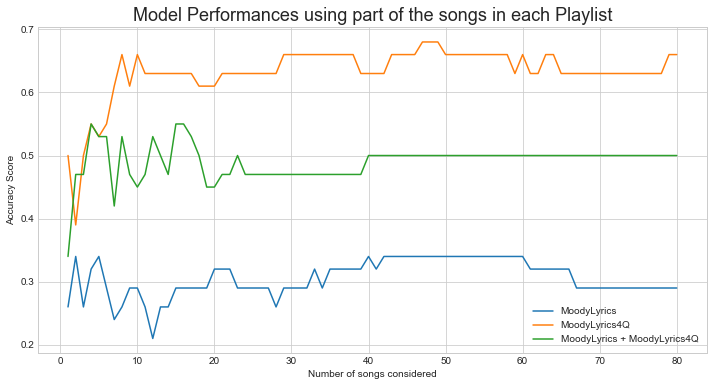

In [33]:
performances = dict()

for t in np.arange(1, 81):
    performances[t] = np.zeros(3)
    
    '''
    FIRST:
    For each model we want to create a dataframe with 
            < Playlist_PID, emotion_vector > 
    where <emotion_vector> is the "mean" of the emotion vectors of the songs in that playlist
    '''
    emotion_labels = ['angry', 'happy','relaxed' ,'sad']
    map_mean = dict()
    for emotion in emotion_labels:
        map_mean[emotion] = 'mean'

    playlistDf_ml_alone = songsFeat_ml_alone\
        .groupby(by='PLAYLIST_PID',as_index=False).head(t)\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)
    playlistDf_ml4q_alone = songsFeat_ml4q_alone\
        .groupby(by='PLAYLIST_PID',as_index=False).head(t)\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)
    playlistDf_ml_ml4q = songsFeat_ml_ml4q\
        .groupby(by='PLAYLIST_PID',as_index=False).head(t)\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)

    '''
    SECOND:
    we join the previous dataframes with the real predictions
    '''

    playlist_testDF.PID = playlist_testDF.PID.astype(int)
    predictions_ml_alone = pd.merge(playlistDf_ml_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
    predictions_ml4q_alone = pd.merge(playlistDf_ml4q_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID'])
    predictions_ml_ml4q = pd.merge(playlistDf_ml_ml4q, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
    
    '''
    Now let's see the accuracies...
    '''
    y_true_labels = [x[6] for x in predictions_ml_alone.values]
    encoder = LabelEncoder()
    y_true = encoder.fit_transform(y_true_labels)

    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
    performances[t][0] = round(accuracy_score(y_true, y_pred),2)
    
    '''
    SECOND MODEL: MoodyLyrics4q alone
    '''
    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
    performances[t][1] = round(accuracy_score(y_true, y_pred),2)
    
    '''
    THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
    '''
    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
    performances[t][2] = round(accuracy_score(y_true, y_pred),2)
    
# Plot what we obtained
x = list(performances.keys())
ml_alone_perf = [performances[k][0] for k in x]
ml4q_alone_perf = [performances[k][1] for k in x]
ml_ml4q_perf = [performances[k][2] for k in x]

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(x, ml_alone_perf, label='MoodyLyrics')
plt.plot(x, ml4q_alone_perf, label='MoodyLyrics4Q')
plt.plot(x, ml_ml4q_perf, label='MoodyLyrics + MoodyLyrics4Q')
plt.legend()
plt.title('Model Performances using part of the songs in each Playlist', fontsize=18)
plt.xlabel('Number of songs considered')
plt.ylabel('Accuracy Score')
plt.savefig('../Report/chapters/chapter5/images/subset-absolute.png')
plt.show()


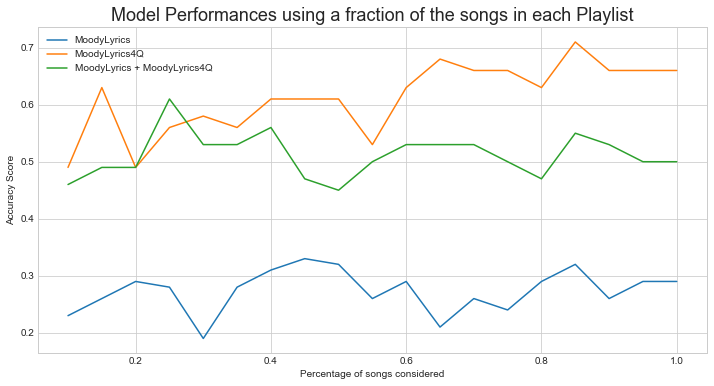

In [34]:
performances = dict()

for t in np.arange(0.1, 1.05, 0.05):
    performances[t] = np.zeros(3)
    
    '''
    FIRST:
    For each model we want to create a dataframe with 
            < Playlist_PID, emotion_vector > 
    where <emotion_vector> is the "mean" of the emotion vectors of the songs in that playlist
    '''
    emotion_labels = ['angry', 'happy','relaxed' ,'sad']
    map_mean = dict()
    for emotion in emotion_labels:
        map_mean[emotion] = 'mean'

    playlistDf_ml_alone = songsFeat_ml_alone\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .apply(lambda x: x.sample(frac=t))\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)
    playlistDf_ml4q_alone = songsFeat_ml4q_alone\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .apply(lambda x: x.sample(frac=t))\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)
    playlistDf_ml_ml4q = songsFeat_ml_ml4q\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .apply(lambda x: x.sample(frac=t))\
        .groupby(by='PLAYLIST_PID',as_index=False)\
        .agg(map_mean)

    '''
    SECOND:
    we join the previous dataframes with the real predictions
    '''

    playlist_testDF.PID = playlist_testDF.PID.astype(int)
    predictions_ml_alone = pd.merge(playlistDf_ml_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
    predictions_ml4q_alone = pd.merge(playlistDf_ml4q_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID'])
    predictions_ml_ml4q = pd.merge(playlistDf_ml_ml4q, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
    
    '''
    Now let's see the accuracies...
    '''
    y_true_labels = [x[6] for x in predictions_ml_alone.values]
    encoder = LabelEncoder()
    y_true = encoder.fit_transform(y_true_labels)

    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
    performances[t][0] = round(accuracy_score(y_true, y_pred),2)
    
    '''
    SECOND MODEL: MoodyLyrics4q alone
    '''
    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
    performances[t][1] = round(accuracy_score(y_true, y_pred),2)
    
    '''
    THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
    '''
    y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
    performances[t][2] = round(accuracy_score(y_true, y_pred),2)
    
# Plot what we obtained
x = sorted(list(performances.keys()))
ml_alone_perf = [performances[k][0] for k in x]
ml4q_alone_perf = [performances[k][1] for k in x]
ml_ml4q_perf = [performances[k][2] for k in x]

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(x, ml_alone_perf, label='MoodyLyrics')
plt.plot(x, ml4q_alone_perf, label='MoodyLyrics4Q')
plt.plot(x, ml_ml4q_perf, label='MoodyLyrics + MoodyLyrics4Q')
plt.legend()
plt.title('Model Performances using a fraction of the songs in each Playlist', fontsize=18)
plt.xlabel('Percentage of songs considered')
plt.ylabel('Accuracy Score')
plt.savefig('../Report/chapters/chapter5/images/subset-percentage.png')
plt.show()

Now let's see what happens when we consider our "robust" classification scheme.

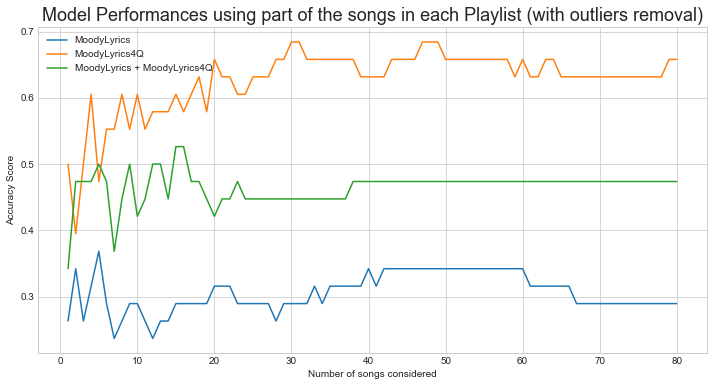

In [35]:
performances = dict()

for t in np.arange(1, 81):
    performances[t] = np.zeros(3)
    data = {
        'ML': songsFeat_ml_alone.groupby(by='PLAYLIST_PID',as_index=False).head(t),
        'ML4Q': songsFeat_ml4q_alone.groupby(by='PLAYLIST_PID',as_index=False).head(t),
        'ML + ML4Q': songsFeat_ml_ml4q.groupby(by='PLAYLIST_PID',as_index=False).head(t)
    }

    y_true = []
    true = {"['happy']": '2', "['angry']": '3', "['sad']": '1' ,"['relaxed']": '0' }

    for name, dataset in data.items():
        outliers_count = 0
        predictions = list()
        for playlist in dataset.PLAYLIST_PID.unique():
            x = dataset[dataset['PLAYLIST_PID'] == playlist][['relaxed', 'sad', 'happy', 'angry']].values
            if name == 'ML':
                true_label = predictions_ml_alone[predictions_ml_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            elif name == 'ML4Q':
                true_label = predictions_ml4q_alone[predictions_ml4q_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            elif name == 'ML + ML4Q':
                true_label = predictions_ml_ml4q[predictions_ml_ml4q['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            pred, outliers_c = robust_classify(x)
            outliers_count += outliers_c
            predictions.append(np.argmax(pred))
        if name == 'ML':
            performances[t][0] = accuracy_score(y_true, predictions)
        elif name == 'ML4Q':
            performances[t][1] = accuracy_score(y_true, predictions)
        elif name == 'ML + ML4Q':
            performances[t][2] = accuracy_score(y_true, predictions)
        y_true = []
# Plot what we obtained
x = list(performances.keys())
ml_alone_perf = [performances[k][0] for k in x]
ml4q_alone_perf = [performances[k][1] for k in x]
ml_ml4q_perf = [performances[k][2] for k in x]

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(x, ml_alone_perf, label='MoodyLyrics')
plt.plot(x, ml4q_alone_perf, label='MoodyLyrics4Q')
plt.plot(x, ml_ml4q_perf, label='MoodyLyrics + MoodyLyrics4Q')
plt.legend()
plt.title('Model Performances using part of the songs in each Playlist (with outliers removal)', fontsize=18)
plt.xlabel('Number of songs considered')
plt.ylabel('Accuracy Score')
plt.savefig('../Report/chapters/chapter5/images/subset-absolute-robust.png')
plt.show()

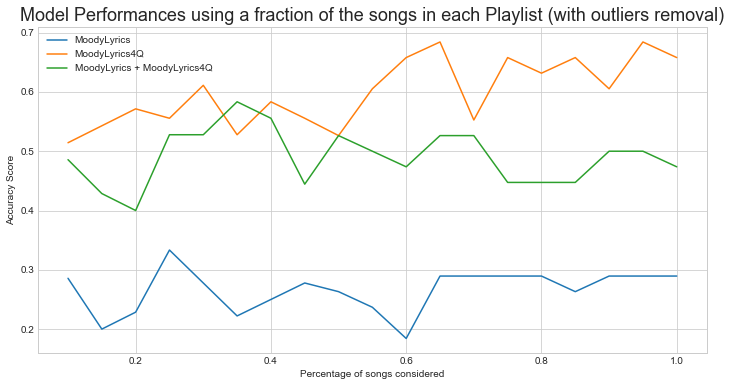

In [36]:
performances = dict()

for t in np.arange(0.1, 1.05, 0.05):
    performances[t] = np.zeros(3)
    data = {
        'ML': songsFeat_ml_alone.groupby(by='PLAYLIST_PID',as_index=False).apply(lambda x: x.sample(frac=t, axis=0)),
        'ML4Q': songsFeat_ml4q_alone.groupby(by='PLAYLIST_PID',as_index=False).apply(lambda x: x.sample(frac=t, axis=0)),
        'ML + ML4Q': songsFeat_ml_ml4q.groupby(by='PLAYLIST_PID',as_index=False).apply(lambda x: x.sample(frac=t, axis=0))
    }

    y_true = []
    true = {"['happy']": '2', "['angry']": '3', "['sad']": '1' ,"['relaxed']": '0' }

    for name, dataset in data.items():
        outliers_count = 0
        predictions = list()
        for playlist in dataset.PLAYLIST_PID.unique():
            x = dataset[dataset['PLAYLIST_PID'] == playlist][['relaxed', 'sad', 'happy', 'angry']].values
            if name == 'ML':
                true_label = predictions_ml_alone[predictions_ml_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            elif name == 'ML4Q':
                true_label = predictions_ml4q_alone[predictions_ml4q_alone['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            elif name == 'ML + ML4Q':
                true_label = predictions_ml_ml4q[predictions_ml_ml4q['PLAYLIST_PID'] == playlist]['Emotion'] 
                y_true.append(int(true[str(true_label.values)]))
            pred, outliers_c = robust_classify(x)
            outliers_count += outliers_c
            predictions.append(np.argmax(pred))
        if name == 'ML':
            performances[t][0] = accuracy_score(y_true, predictions)
        elif name == 'ML4Q':
            performances[t][1] = accuracy_score(y_true, predictions)
        elif name == 'ML + ML4Q':
            performances[t][2] = accuracy_score(y_true, predictions)
        y_true = []
# Plot what we obtained
x = sorted(list(performances.keys()))
ml_alone_perf = [performances[k][0] for k in x]
ml4q_alone_perf = [performances[k][1] for k in x]
ml_ml4q_perf = [performances[k][2] for k in x]

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(x, ml_alone_perf, label='MoodyLyrics')
plt.plot(x, ml4q_alone_perf, label='MoodyLyrics4Q')
plt.plot(x, ml_ml4q_perf, label='MoodyLyrics + MoodyLyrics4Q')
plt.legend()
plt.title('Model Performances using a fraction of the songs in each Playlist (with outliers removal)', fontsize=18)
plt.xlabel('Percentage of songs considered')
plt.ylabel('Accuracy Score')
plt.savefig('../Report/chapters/chapter5/images/subset-percentage-robust.png')
plt.show()

# Emotion Patterns in Playlists

In [108]:
# Compute confusion matrix
def plot_matrix(matrix, title, labels):
    plt.figure(figsize = (5,7))
    plt.title(title,fontsize=20)
    ax = sns.heatmap(matrix, annot=True, cmap='Reds',fmt='g',square=True,linewidths=.7, cbar_kws={"shrink": .5},annot_kws={"size": 12})
    ax.set_xticklabels(labels,fontsize=13, weight='bold', rotation=90)
    b = ax.set_yticklabels(labels,fontsize=13, weight='bold',rotation=360)

In [86]:
columns = ['PLAYLIST_PID','SEQ_ID','angry','happy','relaxed','sad']
'''
Let's create a vector model x (tot_songs) x emotion_label_for_that_model

where for each song we have Playlist_PID and seq_ID 

'''
songsDF_ml_alone = songsFeat_ml_alone[columns]
songsDF_ml4q_alone = songsFeat_ml4q_alone[columns]
songsDF_ml_ml4q = songsFeat_ml_ml4q[columns]
tot = np.zeros((3, songsDF_ml_alone.shape[0], songsDF_ml_alone.shape[1]))

tot[0] = songsDF_ml_alone.values
tot[1] = songsDF_ml4q_alone.values
tot[2] = songsDF_ml_ml4q.values

songs_emotion = np.zeros((3,songsDF_ml_alone.shape[0],3 ))

for i in range(3):
    songs_emotion[i] = np.hstack((tot[i][:,:2], np.argmax(tot[i][:,2:],axis=1).reshape(-1,1)))


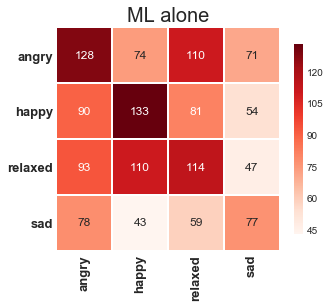

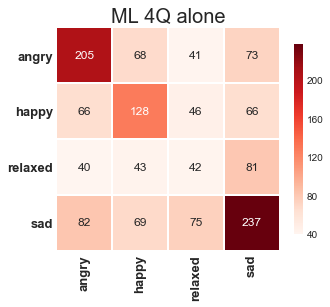

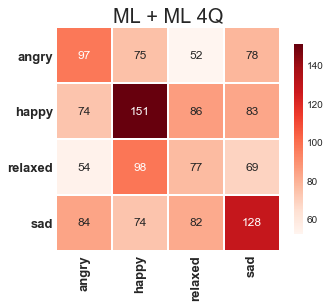

In [109]:
'''
Remember that for some songs we weren't able to download the lyrics.
This means that we have some Seq_IDs missing sometimes.
We want to compute transition from an emotion to the other, so for this task
we will consider only the transition from current seqID and seqID+1.
'''

'''
HOW? 
We will use a 3x (4x4) matrix, where matrix[i][j] is the total count of transition from emotion i to 
emotion j in that playlist. 
Remember that for us 
0 = 'angry'
1 = 'happy'
2 = 'relaxed'
3 = 'sad'

'''
emotion_labels = ['angry','happy','relaxed','sad']

graph = np.zeros((3,4,4))
for i in range(3): 
    for j in range(len(songs_emotion[i])-1):
        # here we have row[0] = Playlist_PID, row[1] = Seq_ID, row[2] = emotion
        if songs_emotion[i][j,1] + 1 == songs_emotion[i][j+1,1] :
            m = int(songs_emotion[i][j,2])
            n = int(songs_emotion[i][j+1,2])
            graph[i][m,n] += 1
            
plot_matrix(graph[0], 'ML alone', emotion_labels)
plot_matrix(graph[1], 'ML 4Q alone', emotion_labels)
plot_matrix(graph[2], 'ML + ML 4Q', emotion_labels)

In [112]:
'''
Let's try to count how many times we go from / to the same emotion
'''

for i in range(3): 
    print('Model ',i, '- sum of the diagonal: ',np.sum(np.diag(graph[i])))

Model  0 - sum of the diagonal:  452.0
Model  1 - sum of the diagonal:  612.0
Model  2 - sum of the diagonal:  453.0


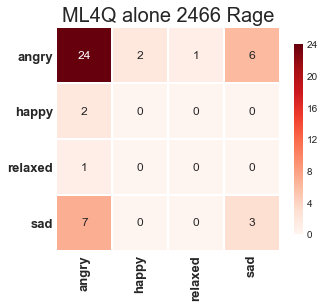

In [130]:
'''
What if we want to see the pattern for a specific playlist? 
Let's define a function to do this

'''
def get_graph(songs_emotion, pid):
    graph = np.zeros((3,4,4))
    for i in range(3): 
        for j in range(len(songs_emotion[i])-1):
            if songs_emotion[i][j,0] == pid:
                # here we have row[0] = Playlist_PID, row[1] = Seq_ID, row[2] = emotion
                if songs_emotion[i][j,1] + 1 == songs_emotion[i][j+1,1] :
                    m = int(songs_emotion[i][j,2])
                    n = int(songs_emotion[i][j+1,2])
                    graph[i][m,n] += 1
    return graph

pid = 2466
my_graph= get_graph(songs_emotion, pid)
plot_matrix(my_graph[1], 'ML4Q alone 2466 Rage', emotion_labels)


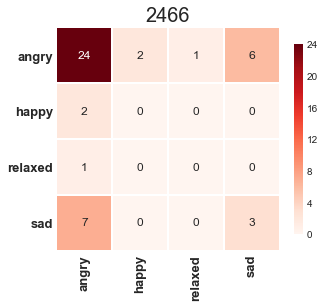

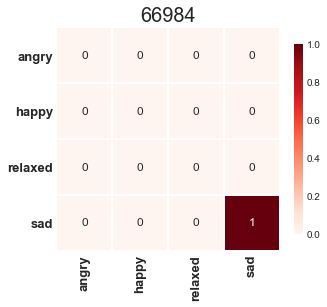

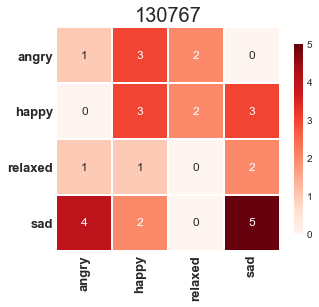

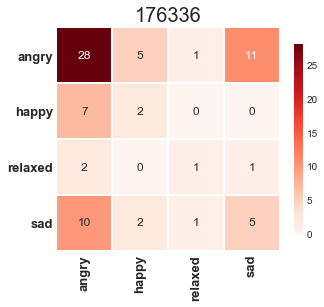

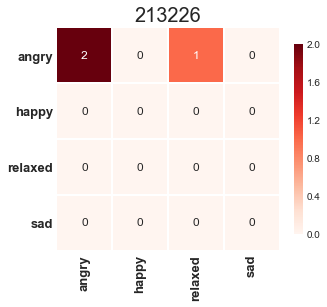

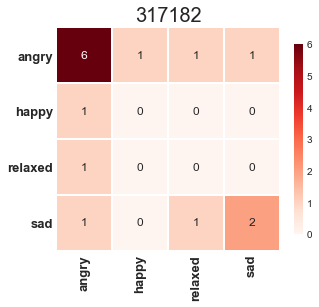

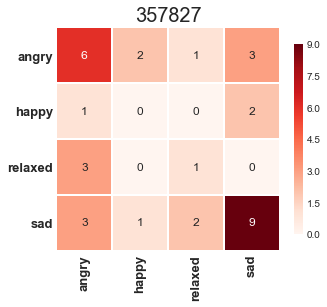

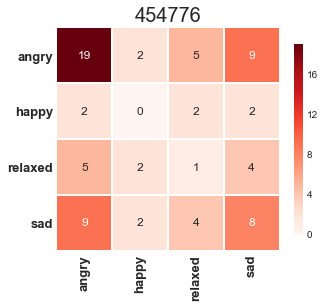

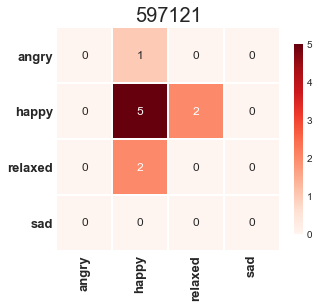

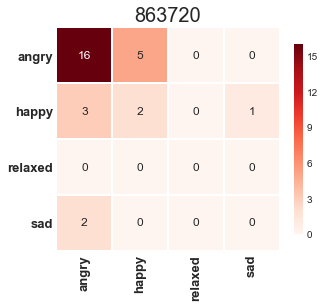

In [139]:
'''
From now we will just consider the model built using ML4Q alone
'''

classified_playlist = pd.read_csv('./datasets/silver_standard/Playlists_c_ML4Q.csv')
angry_pids = classified_playlist[classified_playlist.Emotion == 'angry']['PID']

for pid in angry_pids:
    graph = get_graph(songs_emotion, pid)
    plot_matrix(graph[1],str(pid),emotion_labels)

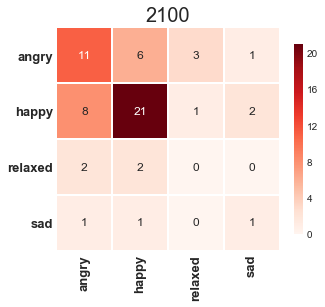

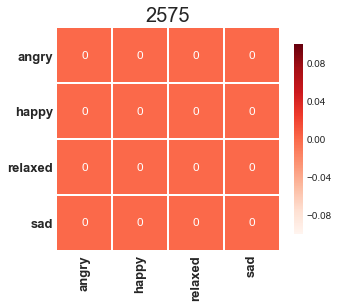

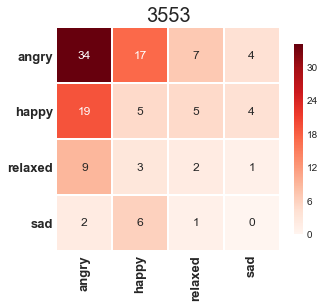

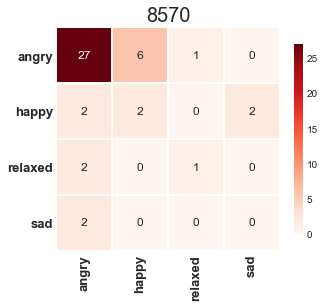

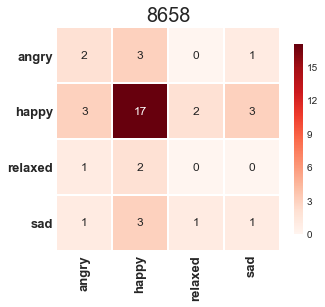

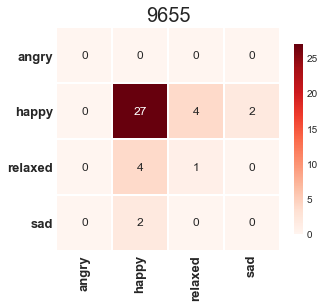

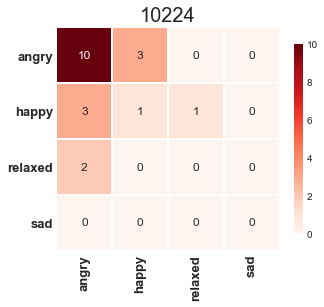

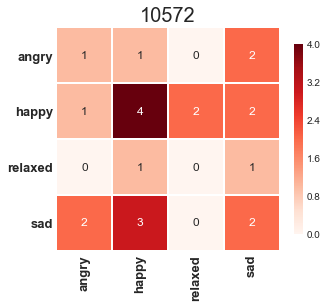

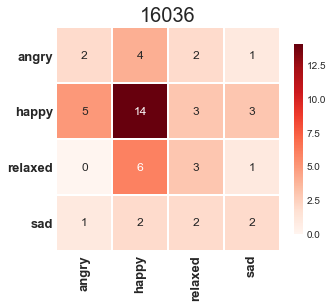

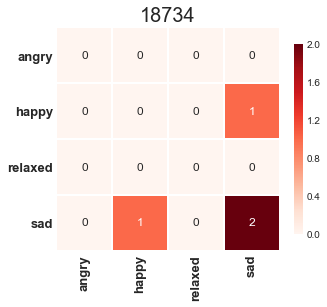

In [140]:
happy_pids = classified_playlist[classified_playlist.Emotion == 'happy']['PID']

for pid in happy_pids:
    graph = get_graph(songs_emotion, pid)
    plot_matrix(graph[1],str(pid),emotion_labels)

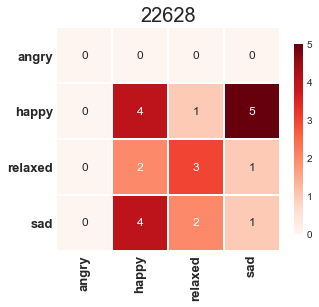

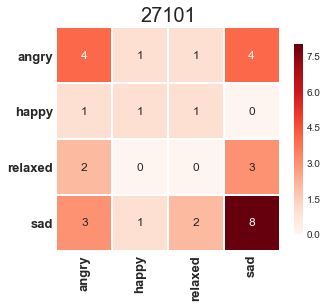

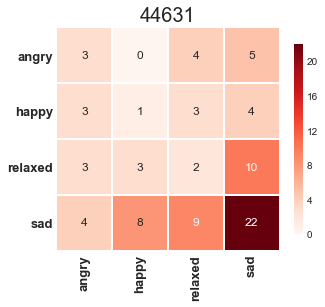

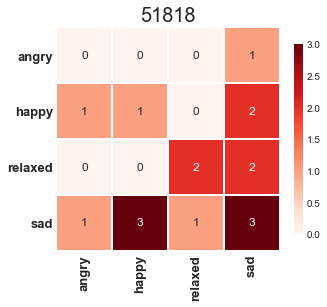

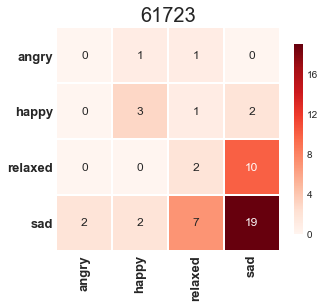

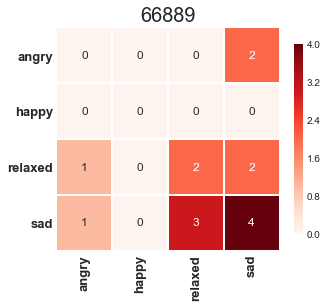

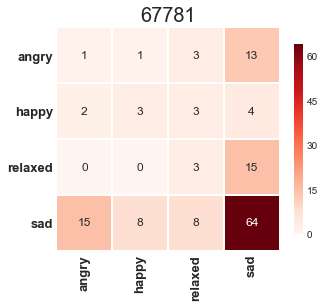

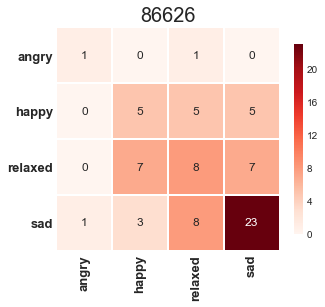

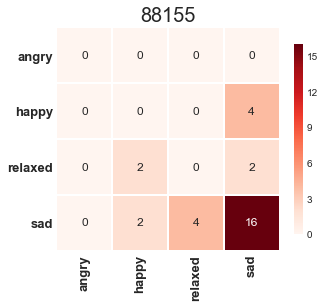

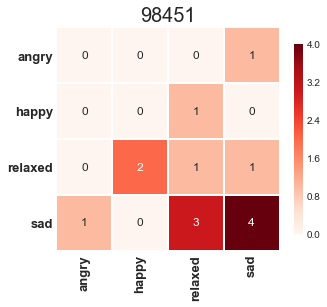

In [141]:
sad_pids = classified_playlist[classified_playlist.Emotion == 'sad']['PID']

for pid in sad_pids:
    graph = get_graph(songs_emotion, pid)
    plot_matrix(graph[1],str(pid),emotion_labels)

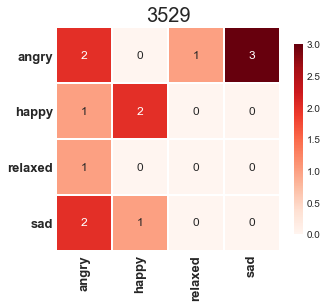

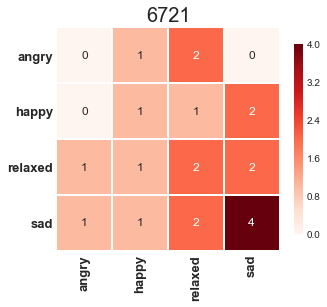

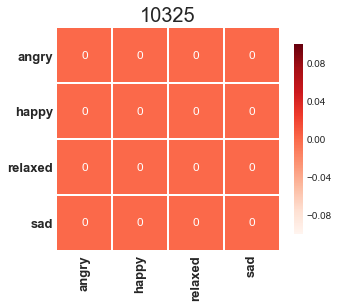

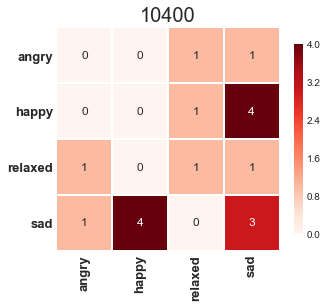

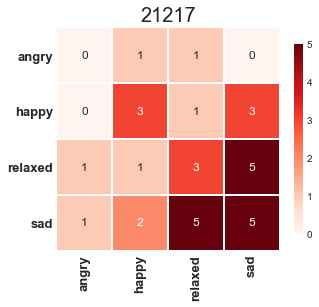

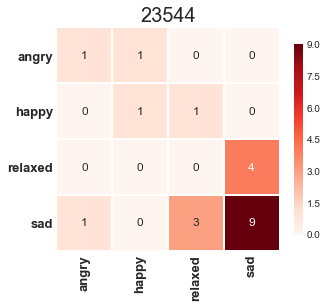

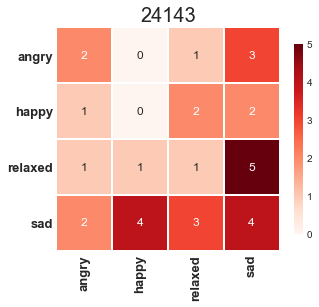

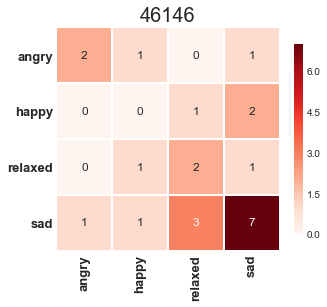

In [142]:
relax_pids = classified_playlist[classified_playlist.Emotion == 'relaxed']['PID']

for pid in relax_pids:
    graph = get_graph(songs_emotion, pid)
    plot_matrix(graph[1],str(pid),emotion_labels)

# Conclusion

<ol>
    <li>Studying qualitatively the difference between MoodyLyrics and MoodyLyrics4Q is not that easy, BUT we compared the 46 duplicates.<br>
        Of these, only 21 are classified differently, and if we consider happy=relaxed and sad=angry only 6/46 are classified differently. <br>
        We tried to analysed 5 of these 6, and we think that MoodyLyrics4Q is right 3 times over 5, not that much to say that it is better, BUT... </li>
    <li> We tried to:
        <ul>
            <li>Use MoodyLyrics as train and MoodyLyrics4Q as test</li>
            <li>Use MoodyLyrics4Q as train and MoodyLyrics as test</li>
            <li>Use just moodyLyrics</li>
            <li>Use just moodyLyrics4Q</li>
            <li>Use both</li>
        </ul>
        and we have the best performances using just MoodyLyrics.<br>
        However when we try to classify the playlists instead of the songs, we get the best performances with MoodyLyrics4Q alone / the joined dataset. </li>
    <li>Given the song classification for each of the three models, we start analysing patterns in playlists.<br>
        With MoodyLyrics4Q alone, we have the greatest sum of the diagonal of the graph, meaning that we loop more time over the same emotion inside a playlist. </li>
    </ol>
    